In [1]:
!python --version

Python 3.13.5


In [3]:
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

from library import load
load()
from lib.pca import biplot, screeplot

In [10]:
[gc.collect(gen) for gen in range(3)]

[0, 0, 0]

In [4]:
fred = pd.read_csv(r"../data/FRED/FRED3_Entire_Database_2021.csv", low_memory=False, header=0, skiprows=range(1, 10), encoding="latin1") # FRED v3
meta = pd.read_csv(r"../data/FRED/FRED3_Column_Definitions_2021.csv", usecols=["column_id", "name", "units"], index_col="column_id") # metadata for FRED v3 (column names, units etc.)

lookup = pd.read_csv(r"../data/plantlookup.csv", low_memory=False, encoding="latin1", index_col=0) # https://github.com/traitecoevo/taxonlookup/releases/download/v1.1.5/plant_lookup.csv
# https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.12517

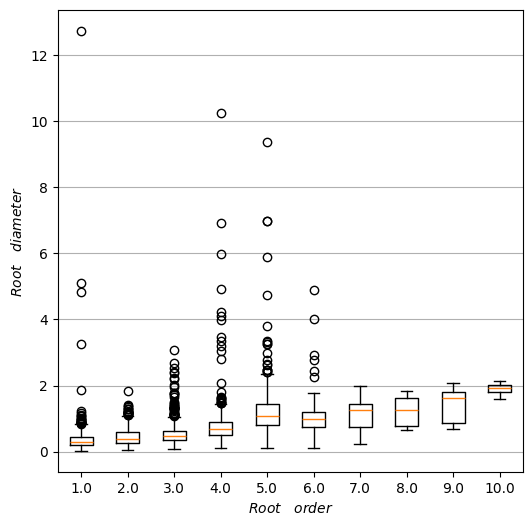

In [5]:
# root order and root diameter

fig, axes = plt.subplots()
fig.set_size_inches(6, 6)
groups = fred.loc[:, ["F00679", "F00056"]].dropna(subset=["F00679", "F00056"]).groupby("F00056")
axes.boxplot([group.F00679 for (_, group) in groups], tick_labels=[order for (order, _) in groups])
# axes.hlines(y=[1, 2], xmin=axes.get_xlim()[0], xmax=axes.get_xlim()[1], color="blue")
axes.set_ylabel(r"$Root\hspace{1}diameter$")
axes.set_xlabel(r"$Root\hspace{1}order$")
axes.grid(which="both", axis='y')
plt.show()

In [6]:
# meta.name[meta.name.str.contains("taxonomy")]

### ___Constants___
-------------

In [7]:
# traits relevent to the root economics space (RES)

COLLABORATION_GRADIENT_TRAITS = [
    "F00679", # RD
    "F00727", # SRL
    # "F00718", #	Specific root area (SRA)
    "F00104", # RCT
    "F00622", # Mycorrhiza_Fraction root length colonized by AM mycorrhizae
    "F00626", # Mycorrhiza_Fraction root length colonized by EM mycorrhizae
    "F00638", # Mycorrhiza_Fraction of root length
    "F00645"  # Mycorrhiza_Type_Data - not technically a root trait, just a relevant info
]

CONSERVATION_GRADIENT_TRAITS = [
    "F00709", # RTD
    "F00277", #	Root P content
    "F00261", # Root N content
    "F00358"  # Root lignin content
]

PLANT_TAXONOMY_ACCEPTED_COLUMNS = [
    "F01286", # Genus of plant according to The Plant List
    "F01287", # Species epithet of plant according to The Plant List
    "F01289", # Family of plant according to The Plant List
    "F01290"  # Order of plant. For Angiosperms, this was determined using the Angiosperm Phylogeny Website (APW): Stevens, P. F. (2001 onwards). Angiosperm Phylogeny Website. 
              # Version 14, July 2017 [and more or less continuously updated since]. Online at http://www.mobot.org/MOBOT/research/APweb/. 
              # For other plant groups (Gymnosperms, Pteridophytes, and Bryophytes) this was determined first using APW, but in cases where there were discrepancies within APW,
              # and to maintain consistency in suffix nomenclature (i.e. all orders ending in “iales”), additional sources were used including the USDA Plants Database 
              # (https://plants.usda.gov/) and the Missouri Botanical Garden (http://www.missouribotanicalgarden.org/plant-science/plant-science/research/plant-identification.aspx).
]

PLANT_TAXONOMY_DATA_SOURCE = [
    "F00017", # family
    "F00018", # genus
    "F00019"  # specific epithet
]

ESSENTIAL_COLUMNS = [
    "F00018", # genus
    "F00019", # species
    "F00056", # root order
    "F00645"  # mycorrhizal type
]

BINOMINAL_NAME = [
    "F00018", # genus name
    "F00019", # specific epithet
    "F01286", # accepted genus name
    "F01287"  # accepted specific epithet
]

In [8]:
fred.loc[:, COLLABORATION_GRADIENT_TRAITS + CONSERVATION_GRADIENT_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].isna().mean()

F00679    0.838835
F00727    0.843627
F00104    0.993828
F00622    0.989596
F00626    0.999685
F00638    0.988390
F00645    0.829148
F00709    0.882847
F00277    0.966550
F00261    0.881728
F00358    0.986693
F00018    0.244029
F00019    0.255499
F00056    0.871533
F00645    0.829148
F01286    0.250743
F01287    0.256478
F01289    0.243189
F01290    0.243015
dtype: float64

In [9]:
# based on the % of nans in the columns of RES traits

CHOSEN_RES_TRAITS = [
    "F00679", # RD
    "F00727", # SRL
    "F00261", # RN
    "F00709"  # RTD
]

CHOSEN_RES_TRAITS_NAMES = ["RD", "SRL", "RN", "RTD"]

### ___Exploratory analyses___
-------------------

In [10]:
# subset the dataframe to pick only the columns with least amount of missing values
fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS]

,F00679,F00727,F00261,F00709,F00018,F00019,F00056,F00645,F01286,F01287,F01289,F01290
0,NaN,NaN,NaN,NaN,Dicranopteris,dichotoma,1.0,AM,Dicranopteris,linearis,Gleicheniaceae,Gleicheniales
1,NaN,NaN,NaN,NaN,Dicranopteris,dichotoma,2.0,AM,Dicranopteris,linearis,Gleicheniaceae,Gleicheniales
2,NaN,NaN,NaN,NaN,Dicranopteris,dichotoma,3.0,AM,Dicranopteris,linearis,Gleicheniaceae,Gleicheniales
3,NaN,NaN,NaN,NaN,Cunninghamia,lanceolata,1.0,AM,Cunninghamia,lanceolata,Cupressaceae,Pinales
4,NaN,NaN,NaN,NaN,Cunninghamia,lanceolata,2.0,AM,Cunninghamia,lanceolata,Cupressaceae,Pinales
...,...,...,...,...,...,...,...,...,...,...,...,...
57185,NaN,0.567694,8.666348,NaN,Diplopterygium,chinense,NaN,NaN,Diplopterygium,chinensis,Gleicheniaceae,Gleicheniales
57186,NaN,0.693820,8.520457,NaN,Diplopterygium,chinense,NaN,NaN,Diplopterygium,chinensis,Gleicheniaceae,Gleicheniales
57187,NaN,3.364970,14.188312,NaN,Osmunda,japonica,NaN,NaN,Osmunda,japonica,Osmundaceae,Osmundaceae
57188,NaN,2.174190,14.849199,NaN,Osmunda,japonica,NaN,NaN,Osmunda,japonica,Osmundaceae,Osmundaceae


In [12]:
# get rid of records with missing values for the 4 chosen root traits
fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS)

,F00679,F00727,F00261,F00709,F00018,F00019,F00056,F00645,F01286,F01287,F01289,F01290
302,0.250000,71.600000,19.700000,0.440000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
303,0.290000,45.900000,14.900000,0.300000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
304,0.380000,68.100000,20.400000,0.320000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
382,0.142951,447.167648,18.478265,0.169294,Populus,trichocarpa,1.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
383,0.249630,166.388374,14.456530,0.160036,Populus,trichocarpa,2.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
...,...,...,...,...,...,...,...,...,...,...,...,...
54941,0.400000,51.410000,16.500000,0.150000,Allium,tenuissimum,NaN,NaN,Allium,tenuissimum,Amaryllidaceae,Asparagales
54942,0.490000,31.670000,16.500000,0.170000,Allium,bidentatum,NaN,NaN,Allium,bidentatum,Amaryllidaceae,Asparagales
54943,0.510000,26.060000,16.500000,0.190000,Allium,bidentatum,NaN,NaN,Allium,bidentatum,Amaryllidaceae,Asparagales
54944,0.230000,102.900000,12.200000,0.230000,Chamaerhodos,erecta,NaN,NaN,Chamaerhodos,erecta,Rosaceae,Rosales


In [13]:
# see whether accepted genus source has info where the data source genus name is missing!!
fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS).query("F00018.isna()") # nada

,F00679,F00727,F00261,F00709,F00018,F00019,F00056,F00645,F01286,F01287,F01289,F01290
302,0.250000,71.600000,19.700000,0.44,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
303,0.290000,45.900000,14.900000,0.30,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
304,0.380000,68.100000,20.400000,0.32,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1603,0.510000,30.160000,12.400000,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1604,0.490000,35.250000,8.200000,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1605,0.510000,32.550000,9.700000,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1606,0.510000,31.770000,9.100000,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1607,0.490000,34.440000,8.300000,0.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1608,0.490000,27.630000,7.000000,0.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1609,0.490000,33.500000,7.100000,0.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# drop the rows that do not have a genus data source (F00018)
fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS + ["F00018"])

,F00679,F00727,F00261,F00709,F00018,F00019,F00056,F00645,F01286,F01287,F01289,F01290
382,0.142951,447.167648,18.478265,0.169294,Populus,trichocarpa,1.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
383,0.249630,166.388374,14.456530,0.160036,Populus,trichocarpa,2.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
384,0.425085,60.723679,10.760881,0.171351,Populus,trichocarpa,3.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
385,0.687417,30.725767,9.130448,0.191318,Populus,trichocarpa,4.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
386,0.175513,330.424588,22.065220,0.169294,Populus,tremula,1.0,NaN,Populus,tremula,Salicaceae,Malpighiales
...,...,...,...,...,...,...,...,...,...,...,...,...
54941,0.400000,51.410000,16.500000,0.150000,Allium,tenuissimum,NaN,NaN,Allium,tenuissimum,Amaryllidaceae,Asparagales
54942,0.490000,31.670000,16.500000,0.170000,Allium,bidentatum,NaN,NaN,Allium,bidentatum,Amaryllidaceae,Asparagales
54943,0.510000,26.060000,16.500000,0.190000,Allium,bidentatum,NaN,NaN,Allium,bidentatum,Amaryllidaceae,Asparagales
54944,0.230000,102.900000,12.200000,0.230000,Chamaerhodos,erecta,NaN,NaN,Chamaerhodos,erecta,Rosaceae,Rosales


In [15]:
# missing values???
fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS + ["F00018"]).isna().mean()

F00679    0.000000
F00727    0.000000
F00261    0.000000
F00709    0.000000
F00018    0.000000
F00019    0.009738
F00056    0.435206
F00645    0.501124
F01286    0.000749
F01287    0.009738
F01289    0.014981
F01290    0.014981
dtype: float64

In [16]:
# root order and mycorrhizal type still have lots of NAs

In [17]:
# including root order (F00056) in NA removal columns
fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS + ["F00018", "F00056"])

,F00679,F00727,F00261,F00709,F00018,F00019,F00056,F00645,F01286,F01287,F01289,F01290
382,0.142951,447.167648,18.478265,0.169294,Populus,trichocarpa,1.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
383,0.249630,166.388374,14.456530,0.160036,Populus,trichocarpa,2.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
384,0.425085,60.723679,10.760881,0.171351,Populus,trichocarpa,3.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
385,0.687417,30.725767,9.130448,0.191318,Populus,trichocarpa,4.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
386,0.175513,330.424588,22.065220,0.169294,Populus,tremula,1.0,NaN,Populus,tremula,Salicaceae,Malpighiales
...,...,...,...,...,...,...,...,...,...,...,...,...
45575,0.042154,81.443333,19.366667,0.103333,Prunus,sargentii,1.0,NaN,Prunus,sargentii,Rosaceae,Rosales
45576,0.219538,20.513333,23.200000,0.116667,Sassafras,albidum,1.0,NaN,Sassafras,albidum,Lauraceae,Laurales
45577,0.086988,36.817500,26.300000,0.155000,Styphnolobium,japonicum,1.0,NaN,Styphnolobium,japonicum,Fabaceae,Fabales
45578,0.061422,89.920000,23.900000,0.075000,Syringa,reticulata,1.0,NaN,Syringa,reticulata,Oleaceae,Lamiales


In [18]:
# including mycorrhizal type (F00645) in NA removal columns
fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS + ["F00018", "F00645"])

,F00679,F00727,F00261,F00709,F00018,F00019,F00056,F00645,F01286,F01287,F01289,F01290
1553,0.3100,23.800000,13.01,0.550000,Aristotelia,serrata,NaN,AM,Aristotelia,serrata,Elaeocarpaceae,Oxalidales
1554,0.5300,22.200000,9.01,0.200000,Ascarina,lucida,NaN,AM,Ascarina,lucida,Chloranthaceae,Chloranthales
1555,0.4300,31.800000,16.18,0.200000,Asplenium,bulbiferum,NaN,AM,Asplenium,bulbiferum,Aspleniaceae,Polypodiales
1556,0.9400,12.900000,10.12,0.090000,Astelia,fragrans,NaN,AM,Astelia,fragrans,Asteliaceae,Asparagales
1557,0.9500,14.500000,6.49,0.090000,Astelia,nervosa,NaN,AM,Astelia,nervosa,Asteliaceae,Asparagales
...,...,...,...,...,...,...,...,...,...,...,...,...
42456,0.3641,55.618299,9.80,0.172743,Weinmannia,silvicola,NaN,AM,Weinmannia,silvicola,Cunoniaceae,Oxalidales
42457,0.3474,65.650773,9.80,0.160465,Weinmannia,silvicola,NaN,AM,Weinmannia,silvicola,Cunoniaceae,Oxalidales
42458,0.4144,38.274731,9.80,0.193932,Weinmannia,silvicola,NaN,AM,Weinmannia,silvicola,Cunoniaceae,Oxalidales
42459,0.3619,61.581617,9.80,0.157944,Weinmannia,silvicola,NaN,AM,Weinmannia,silvicola,Cunoniaceae,Oxalidales


In [19]:
# including root order and mycorrhizal type in NA removal columns
# fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS + ["F00018", "F00056", "F00645"])

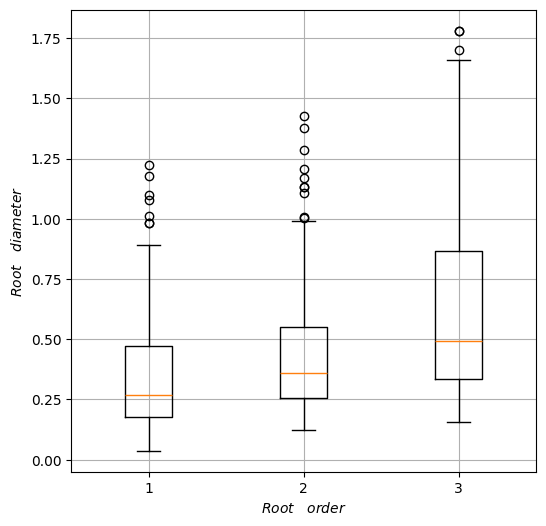

In [20]:
# what is the root diameter distribution of fine roots (orders 1, 2, 3)

fig, axes = plt.subplots()
fig.set_size_inches(6, 6)
axes.boxplot([group.F00679 for (_, group) in fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS + ["F00018"]).query("F00056.isin((1, 2, 3))").groupby("F00056")])
axes.set_ylabel(r"$Root\hspace{1}diameter$")
axes.set_xlabel(r"$Root\hspace{1}order$")
axes.grid()
plt.show()

In [18]:
# if available in literature, mycorrhizal type can be manually added so do not prioritize that for now
# when root order is missing include the record only if the root diamater is less than 1 mm

fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS + ["F00018"]).\
                                                    query("F00056.isin((1, 2, 3))")# & (F00056 < 2.00))")# or (F00056.isna() and (F00679 < 1.000))")

,F00679,F00727,F00261,F00709,F00018,F00019,F00056,F00645,F01286,F01287,F01289,F01290
382,0.142951,447.167648,18.478265,0.169294,Populus,trichocarpa,1.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
383,0.249630,166.388374,14.456530,0.160036,Populus,trichocarpa,2.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
384,0.425085,60.723679,10.760881,0.171351,Populus,trichocarpa,3.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
386,0.175513,330.424588,22.065220,0.169294,Populus,tremula,1.0,NaN,Populus,tremula,Salicaceae,Malpighiales
387,0.285828,116.664475,16.304355,0.160041,Populus,tremula,2.0,NaN,Populus,tremula,Salicaceae,Malpighiales
...,...,...,...,...,...,...,...,...,...,...,...,...
45575,0.042154,81.443333,19.366667,0.103333,Prunus,sargentii,1.0,NaN,Prunus,sargentii,Rosaceae,Rosales
45576,0.219538,20.513333,23.200000,0.116667,Sassafras,albidum,1.0,NaN,Sassafras,albidum,Lauraceae,Laurales
45577,0.086988,36.817500,26.300000,0.155000,Styphnolobium,japonicum,1.0,NaN,Styphnolobium,japonicum,Fabaceae,Fabales
45578,0.061422,89.920000,23.900000,0.075000,Syringa,reticulata,1.0,NaN,Syringa,reticulata,Oleaceae,Lamiales


In [29]:
# what's the max root diamater of the above subset???
fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS + ["F00018"]).query("F00056.isin((1, 2, 3))").F00679.max()

np.float64(1.7806)

In [30]:
# missing values???
fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS + ["F00018"]).query("F00056.isin((1, 2, 3)) or (F00056.isna() and (F00679 < 1.000))").isna().mean()

F00679    0.000000
F00727    0.000000
F00261    0.000000
F00709    0.000000
F00018    0.000000
F00019    0.012476
F00056    0.421305
F00645    0.465451
F01286    0.000960
F01287    0.012476
F01289    0.009597
F01290    0.009597
dtype: float64

In [31]:
# why not consider specific epithet for the NA removal???
fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS + BINOMINAL_NAME).query("F00056.isin((1, 2, 3)) or (F00056.isna() and (F00679 < 1.000))")

,F00679,F00727,F00261,F00709,F00018,F00019,F00056,F00645,F01286,F01287,F01289,F01290
382,0.142951,447.167648,18.478265,0.169294,Populus,trichocarpa,1.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
383,0.249630,166.388374,14.456530,0.160036,Populus,trichocarpa,2.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
384,0.425085,60.723679,10.760881,0.171351,Populus,trichocarpa,3.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
386,0.175513,330.424588,22.065220,0.169294,Populus,tremula,1.0,NaN,Populus,tremula,Salicaceae,Malpighiales
387,0.285828,116.664475,16.304355,0.160041,Populus,tremula,2.0,NaN,Populus,tremula,Salicaceae,Malpighiales
...,...,...,...,...,...,...,...,...,...,...,...,...
54941,0.400000,51.410000,16.500000,0.150000,Allium,tenuissimum,NaN,NaN,Allium,tenuissimum,Amaryllidaceae,Asparagales
54942,0.490000,31.670000,16.500000,0.170000,Allium,bidentatum,NaN,NaN,Allium,bidentatum,Amaryllidaceae,Asparagales
54943,0.510000,26.060000,16.500000,0.190000,Allium,bidentatum,NaN,NaN,Allium,bidentatum,Amaryllidaceae,Asparagales
54944,0.230000,102.900000,12.200000,0.230000,Chamaerhodos,erecta,NaN,NaN,Chamaerhodos,erecta,Rosaceae,Rosales


In [40]:
# why not consider specific epithet for the NA removal???
fred.loc[:, CHOSEN_RES_TRAITS + ["F00056", "F00645"] + PLANT_TAXONOMY_ACCEPTED_COLUMNS].\
                dropna(subset=CHOSEN_RES_TRAITS + PLANT_TAXONOMY_ACCEPTED_COLUMNS).\
                    query("F00056.isin((1, 2, 3)) or (F00056.isna() and (F00679 < 1.000))")

,F00679,F00727,F00261,F00709,F00056,F00645,F01286,F01287,F01289,F01290
382,0.142951,447.167648,18.478265,0.169294,1.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
383,0.249630,166.388374,14.456530,0.160036,2.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
384,0.425085,60.723679,10.760881,0.171351,3.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
386,0.175513,330.424588,22.065220,0.169294,1.0,NaN,Populus,tremula,Salicaceae,Malpighiales
387,0.285828,116.664475,16.304355,0.160041,2.0,NaN,Populus,tremula,Salicaceae,Malpighiales
...,...,...,...,...,...,...,...,...,...,...
54941,0.400000,51.410000,16.500000,0.150000,NaN,NaN,Allium,tenuissimum,Amaryllidaceae,Asparagales
54942,0.490000,31.670000,16.500000,0.170000,NaN,NaN,Allium,bidentatum,Amaryllidaceae,Asparagales
54943,0.510000,26.060000,16.500000,0.190000,NaN,NaN,Allium,bidentatum,Amaryllidaceae,Asparagales
54944,0.230000,102.900000,12.200000,0.230000,NaN,NaN,Chamaerhodos,erecta,Rosaceae,Rosales


### ___Subsetting___
---------------

In [11]:
# FINE ABSORPTIVE ROOTS

# in our subset fine roots means roots of orders 1, 2 or 3 
# OR roots with diameter less than 1 mm (being more stringent here because the order is unknown) - TURNED OUT TO BE A BAD IDEA
data = fred.loc[:, CHOSEN_RES_TRAITS + ["F00056", "F00645"] + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS + PLANT_TAXONOMY_ACCEPTED_COLUMNS).\
                        query("F00056.isin((1, 2, 3))").reset_index(drop=True)

In [12]:
data

,F00679,F00727,F00261,F00709,F00056,F00645,F01286,F01287,F01289,F01290
0,0.142951,447.167648,18.478265,0.169294,1.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
1,0.249630,166.388374,14.456530,0.160036,2.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
2,0.425085,60.723679,10.760881,0.171351,3.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
3,0.175513,330.424588,22.065220,0.169294,1.0,NaN,Populus,tremula,Salicaceae,Malpighiales
4,0.285828,116.664475,16.304355,0.160041,2.0,NaN,Populus,tremula,Salicaceae,Malpighiales
...,...,...,...,...,...,...,...,...,...,...
598,0.042154,81.443333,19.366667,0.103333,1.0,NaN,Prunus,sargentii,Rosaceae,Rosales
599,0.219538,20.513333,23.200000,0.116667,1.0,NaN,Sassafras,albidum,Lauraceae,Laurales
600,0.086988,36.817500,26.300000,0.155000,1.0,NaN,Styphnolobium,japonicum,Fabaceae,Fabales
601,0.061422,89.920000,23.900000,0.075000,1.0,NaN,Syringa,reticulata,Oleaceae,Lamiales


In [13]:
data.F00056.isna().mean(), (data.F00679 < 1.000).mean()

(np.float64(0.0), np.float64(0.9303482587064676))

In [14]:
data.isna().mean()

F00679    0.000000
F00727    0.000000
F00261    0.000000
F00709    0.000000
F00056    0.000000
F00645    0.371476
F01286    0.000000
F01287    0.000000
F01289    0.000000
F01290    0.000000
dtype: float64

In [15]:
data.F00056.value_counts(dropna=False)

F00056
1.0    294
3.0    157
2.0    152
Name: count, dtype: int64

### ___Taxonomic corrections in the subset___
-------------------------

In [16]:
lookup

,family,order,group
genus,,,
Acorus,Acoraceae,Acorales,Angiosperms
Albidella,Alismataceae,Alismatales,Angiosperms
Alisma,Alismataceae,Alismatales,Angiosperms
Astonia,Alismataceae,Alismatales,Angiosperms
Baldellia,Alismataceae,Alismatales,Angiosperms
...,...,...,...
Ugena,Lygodiaceae,Schizaeales,Pteridophytes
Actinostachys,Schizaeaceae,Schizaeales,Pteridophytes
Lophidium,Schizaeaceae,Schizaeales,Pteridophytes


In [17]:
# taxonomic conflicts between data source and accepted info
# (data.F00018 != data.F01286).sum(), (data.F00019 != data.F01287).sum()

In [18]:
# genus
# data.query("F00018 != F01286").loc[:, BINOMINAL_NAME].shape, data.query("F00018 != F01286").loc[:, BINOMINAL_NAME].drop_duplicates().shape

In [19]:
# specific epithet
# data.query("F00019 != F01287").loc[:, BINOMINAL_NAME].shape, data.query("F00019 != F01287").loc[:, BINOMINAL_NAME].drop_duplicates().shape

In [20]:
# data.query("F00019 != F01287").loc[:, BINOMINAL_NAME].drop_duplicates()

In [21]:
# family conflicts
# whether a genus is classified under multiple families
np.array([data.query("F01286==@genus").F01289.unique().size for genus in data.F01286.unique()], dtype=np.uint32).max()

np.uint32(2)

In [22]:
# where???
np.where(np.array([data.query("F01286==@genus").F01289.unique().size for genus in data.F01286.unique()], dtype=np.uint32) > 1)

(array([26]),)

In [23]:
# order conflicts
# whether a genus is classified under multiple orders
np.array([data.query("F01286==@genus").F01290.unique().size for genus in data.F01286.unique()], dtype=np.uint32).max()

np.uint32(2)

In [24]:
# where???
np.where(np.array([data.query("F01286==@genus").F01290.unique().size for genus in data.F01286.unique()], dtype=np.uint32) > 1)

(array([26]),)

In [25]:
# what's the 26th record???
data.F01286.unique()[26]

'Platanus'

In [26]:
data.query("F01286==\"Platanus\"")

,F00679,F00727,F00261,F00709,F00056,F00645,F01286,F01287,F01289,F01290
126,0.486750,11.977390,9.219875,0.1490,1.0,AM,Platanus,occidentalis,Platanaceae,Proteales
127,1.169600,3.218217,6.524208,0.3000,2.0,AM,Platanus,occidentalis,Platanaceae,Proteales
128,0.416000,23.929697,13.021250,0.1500,3.0,AM,Platanus,occidentalis,Platanaceae,Proteales
596,0.282061,23.930000,13.000000,0.1475,1.0,NaN,Platanus,acerifolia,Sapindaceae,Sapindales


In [27]:
# the correct taxonomy for genus Platanus is
lookup.loc["Platanus"]

family    Platanaceae
order       Proteales
group     Angiosperms
Name: Platanus, dtype: object

In [28]:
# the incorrect record for Platanus in the subset
data.loc[596, :]

F00679       0.282061
F00727          23.93
F00261           13.0
F00709         0.1475
F00056            1.0
F00645            NaN
F01286       Platanus
F01287     acerifolia
F01289    Sapindaceae
F01290     Sapindales
Name: 596, dtype: object

In [29]:
# fix it
data.loc[596, "F01289"] = "Platanaceae"
data.loc[596, "F01290"] = "Proteales"

In [30]:
# :)
print(
    np.array([data.query("F01286==@genus").F01289.unique().size for genus in data.F01286.unique()], dtype=np.uint32).max(),
    np.array([data.query("F01286==@genus").F01290.unique().size for genus in data.F01286.unique()], dtype=np.uint32).max()
)

1 1


In [31]:
# try looking up using the accepted genus name instead of the data source???
lookup.loc[data.F01286]

,family,order,group
genus,,,
Populus,Salicaceae,Malpighiales,Angiosperms
Populus,Salicaceae,Malpighiales,Angiosperms
Populus,Salicaceae,Malpighiales,Angiosperms
Populus,Salicaceae,Malpighiales,Angiosperms
Populus,Salicaceae,Malpighiales,Angiosperms
...,...,...,...
Prunus,Rosaceae,Rosales,Angiosperms
Sassafras,Lauraceae,Laurales,Angiosperms
Styphnolobium,Fabaceae,Fabales,Angiosperms


In [32]:
data.query("F01286==\"Prinostemma\"") # the correct name is Prionostemma aspera

,F00679,F00727,F00261,F00709,F00056,F00645,F01286,F01287,F01289,F01290


In [33]:
# correct that name in data
# data.F01286 = data.F01286.replace({"Prinostemma": "Prionostemma"})

In [34]:
lookup.loc[data.F01286]

,family,order,group
genus,,,
Populus,Salicaceae,Malpighiales,Angiosperms
Populus,Salicaceae,Malpighiales,Angiosperms
Populus,Salicaceae,Malpighiales,Angiosperms
Populus,Salicaceae,Malpighiales,Angiosperms
Populus,Salicaceae,Malpighiales,Angiosperms
...,...,...,...
Prunus,Rosaceae,Rosales,Angiosperms
Sassafras,Lauraceae,Laurales,Angiosperms
Styphnolobium,Fabaceae,Fabales,Angiosperms


In [35]:
# we do not have missing values in the taxonomy columns
data.isna().mean()

F00679    0.000000
F00727    0.000000
F00261    0.000000
F00709    0.000000
F00056    0.000000
F00645    0.371476
F01286    0.000000
F01287    0.000000
F01289    0.000000
F01290    0.000000
dtype: float64

In [36]:
# fixing Rubiaceae
data.F01289 = data.F01289.replace("Rubiaceae ", "Rubiaceae")

In [37]:
data.shape[0] - data.F00056.isna().sum()

np.int64(603)

In [38]:
combined = pd.merge(left=data, right=lookup, left_on="F01286", right_index=True) # lookup's index is genus names so;
combined

,F00679,F00727,F00261,F00709,F00056,F00645,F01286,F01287,F01289,F01290,family,order,group
0,0.142951,447.167648,18.478265,0.169294,1.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales,Salicaceae,Malpighiales,Angiosperms
1,0.249630,166.388374,14.456530,0.160036,2.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales,Salicaceae,Malpighiales,Angiosperms
2,0.425085,60.723679,10.760881,0.171351,3.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales,Salicaceae,Malpighiales,Angiosperms
3,0.175513,330.424588,22.065220,0.169294,1.0,NaN,Populus,tremula,Salicaceae,Malpighiales,Salicaceae,Malpighiales,Angiosperms
4,0.285828,116.664475,16.304355,0.160041,2.0,NaN,Populus,tremula,Salicaceae,Malpighiales,Salicaceae,Malpighiales,Angiosperms
...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,0.042154,81.443333,19.366667,0.103333,1.0,NaN,Prunus,sargentii,Rosaceae,Rosales,Rosaceae,Rosales,Angiosperms
599,0.219538,20.513333,23.200000,0.116667,1.0,NaN,Sassafras,albidum,Lauraceae,Laurales,Lauraceae,Laurales,Angiosperms
600,0.086988,36.817500,26.300000,0.155000,1.0,NaN,Styphnolobium,japonicum,Fabaceae,Fabales,Fabaceae,Fabales,Angiosperms
601,0.061422,89.920000,23.900000,0.075000,1.0,NaN,Syringa,reticulata,Oleaceae,Lamiales,Oleaceae,Lamiales,Angiosperms


In [46]:
# family level conflicts
combined.query("F01289!=family").loc[:, ["F01286", "F01287", "F01289", "F01290", "family", "order", "group"]]#.drop_duplicates()

,F01286,F01287,F01289,F01290,family,order,group


In [47]:
# NEED TO DO THIS FOR data AS WELL!!!!!
# combined.F01289.value_counts()["Rubiaceae "]

In [48]:
combined.query("F01289!=family").loc[:, "F01289"].drop_duplicates()

Series([], Name: F01289, dtype: object)

In [49]:
# order level conflicts
combined.query("F01290!=order").loc[:, ["F01286", "F01287", "F01289", "F01290", "family", "order", "group"]].\
    drop_duplicates().sort_values(by=["F01286", "F01287", "F01289", "F01290"])#.shape

,F01286,F01287,F01289,F01290,family,order,group
249,Athyrium,multidentatum,Athyriaceae,Polypodiales,Athyriaceae,Eupolypod II,Pteridophytes
252,Athyrium,sinense,Athyriaceae,Polypodiales,Athyriaceae,Eupolypod II,Pteridophytes
270,Athyrium,spinulosum,Athyriaceae,Polypodiales,Athyriaceae,Eupolypod II,Pteridophytes
255,Cystopteris,sudetica,Cystopteridaceae,Polypodiales,Cystopteridaceae,Polypodiales-Eupolypod II,Pteridophytes
264,Matteuccia,struthiopteris,Onocleaceae,Polypodiales,Onocleaceae,Eupolypod II,Pteridophytes
267,Onoclea,sensibilis,Onocleaceae,Polypodiales,Onocleaceae,Eupolypod II,Pteridophytes


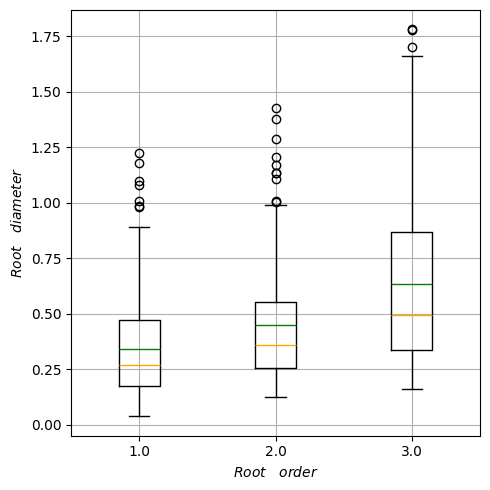

In [39]:
fig, axes = plt.subplots()
fig.set_size_inches(5, 5)
axes.boxplot([group.F00679 for (_, group) in data.groupby("F00056", dropna=False)], 
             tick_labels=[label for (label, _) in data.groupby("F00056", dropna=False)],
             meanprops={"color": "green", "linestyle": "-"}, showmeans=True,
             medianprops={"color": "orange", "linestyle": "-"}, meanline=True)
axes.grid()
axes.set_xlabel(r"$Root\hspace{1}order$")
axes.set_ylabel(r"$Root\hspace{1}diameter$")
plt.tight_layout()
# plt.savefig(fname=r"../plots/fred_rd_ro.jpeg", format="jpeg", dpi=500)
plt.show()

In [52]:
data.loc[:, ["F01286", "F01287", "F01289", "F01290"]].apply(lambda column: column.unique().size)

F01286    121
F01287    185
F01289     60
F01290     26
dtype: int64

In [63]:
combined.groupby(["F01286", "F01287"]).count()

F00679  F00727  F00261  F00709  F00056  F00645  \
F01286     F01287                                                           
Acacia     auriculiformis       4       4       4       4       4       1   
           crassicarpa          1       1       1       1       1       1   
           mangium              1       1       1       1       1       1   
Acer       davidii              3       3       3       3       3       3   
           fabri                1       1       1       1       1       1   
...                           ...     ...     ...     ...     ...     ...   
Ulmus      americana            4       4       4       4       4       3   
           davidiana            3       3       3       3       3       3   
           macrocarpa           3       3       3       3       3       3   
Vaccinium  mandarinorum         1       1       1       1       1       1   
Wendlandia uvariifolia          1       1       1       1       1       1   

                           F01289  F01290  family  order  group  
F01286     F01287                                                
Acacia     auriculiformis       4       4       4      4      4  
           crassicarpa          1       1       1      1      1  
           mangium              1       1       1      1      1  
Acer       davidii              3       3       3      3      3  
           fabri                1       1       1      1      1  
...                           ...     ...     ...    ...    ...  
Ulmus      americana            4       4       4      4      4  
           davidiana            3       3       3      3      3  
           macrocarpa           3       3       3      3      3  
Vaccinium  mandarinorum         1       1       1      1      1  
Wendlandia uvariifolia          1       1       1      1      1  

[203 rows x 11 columns]

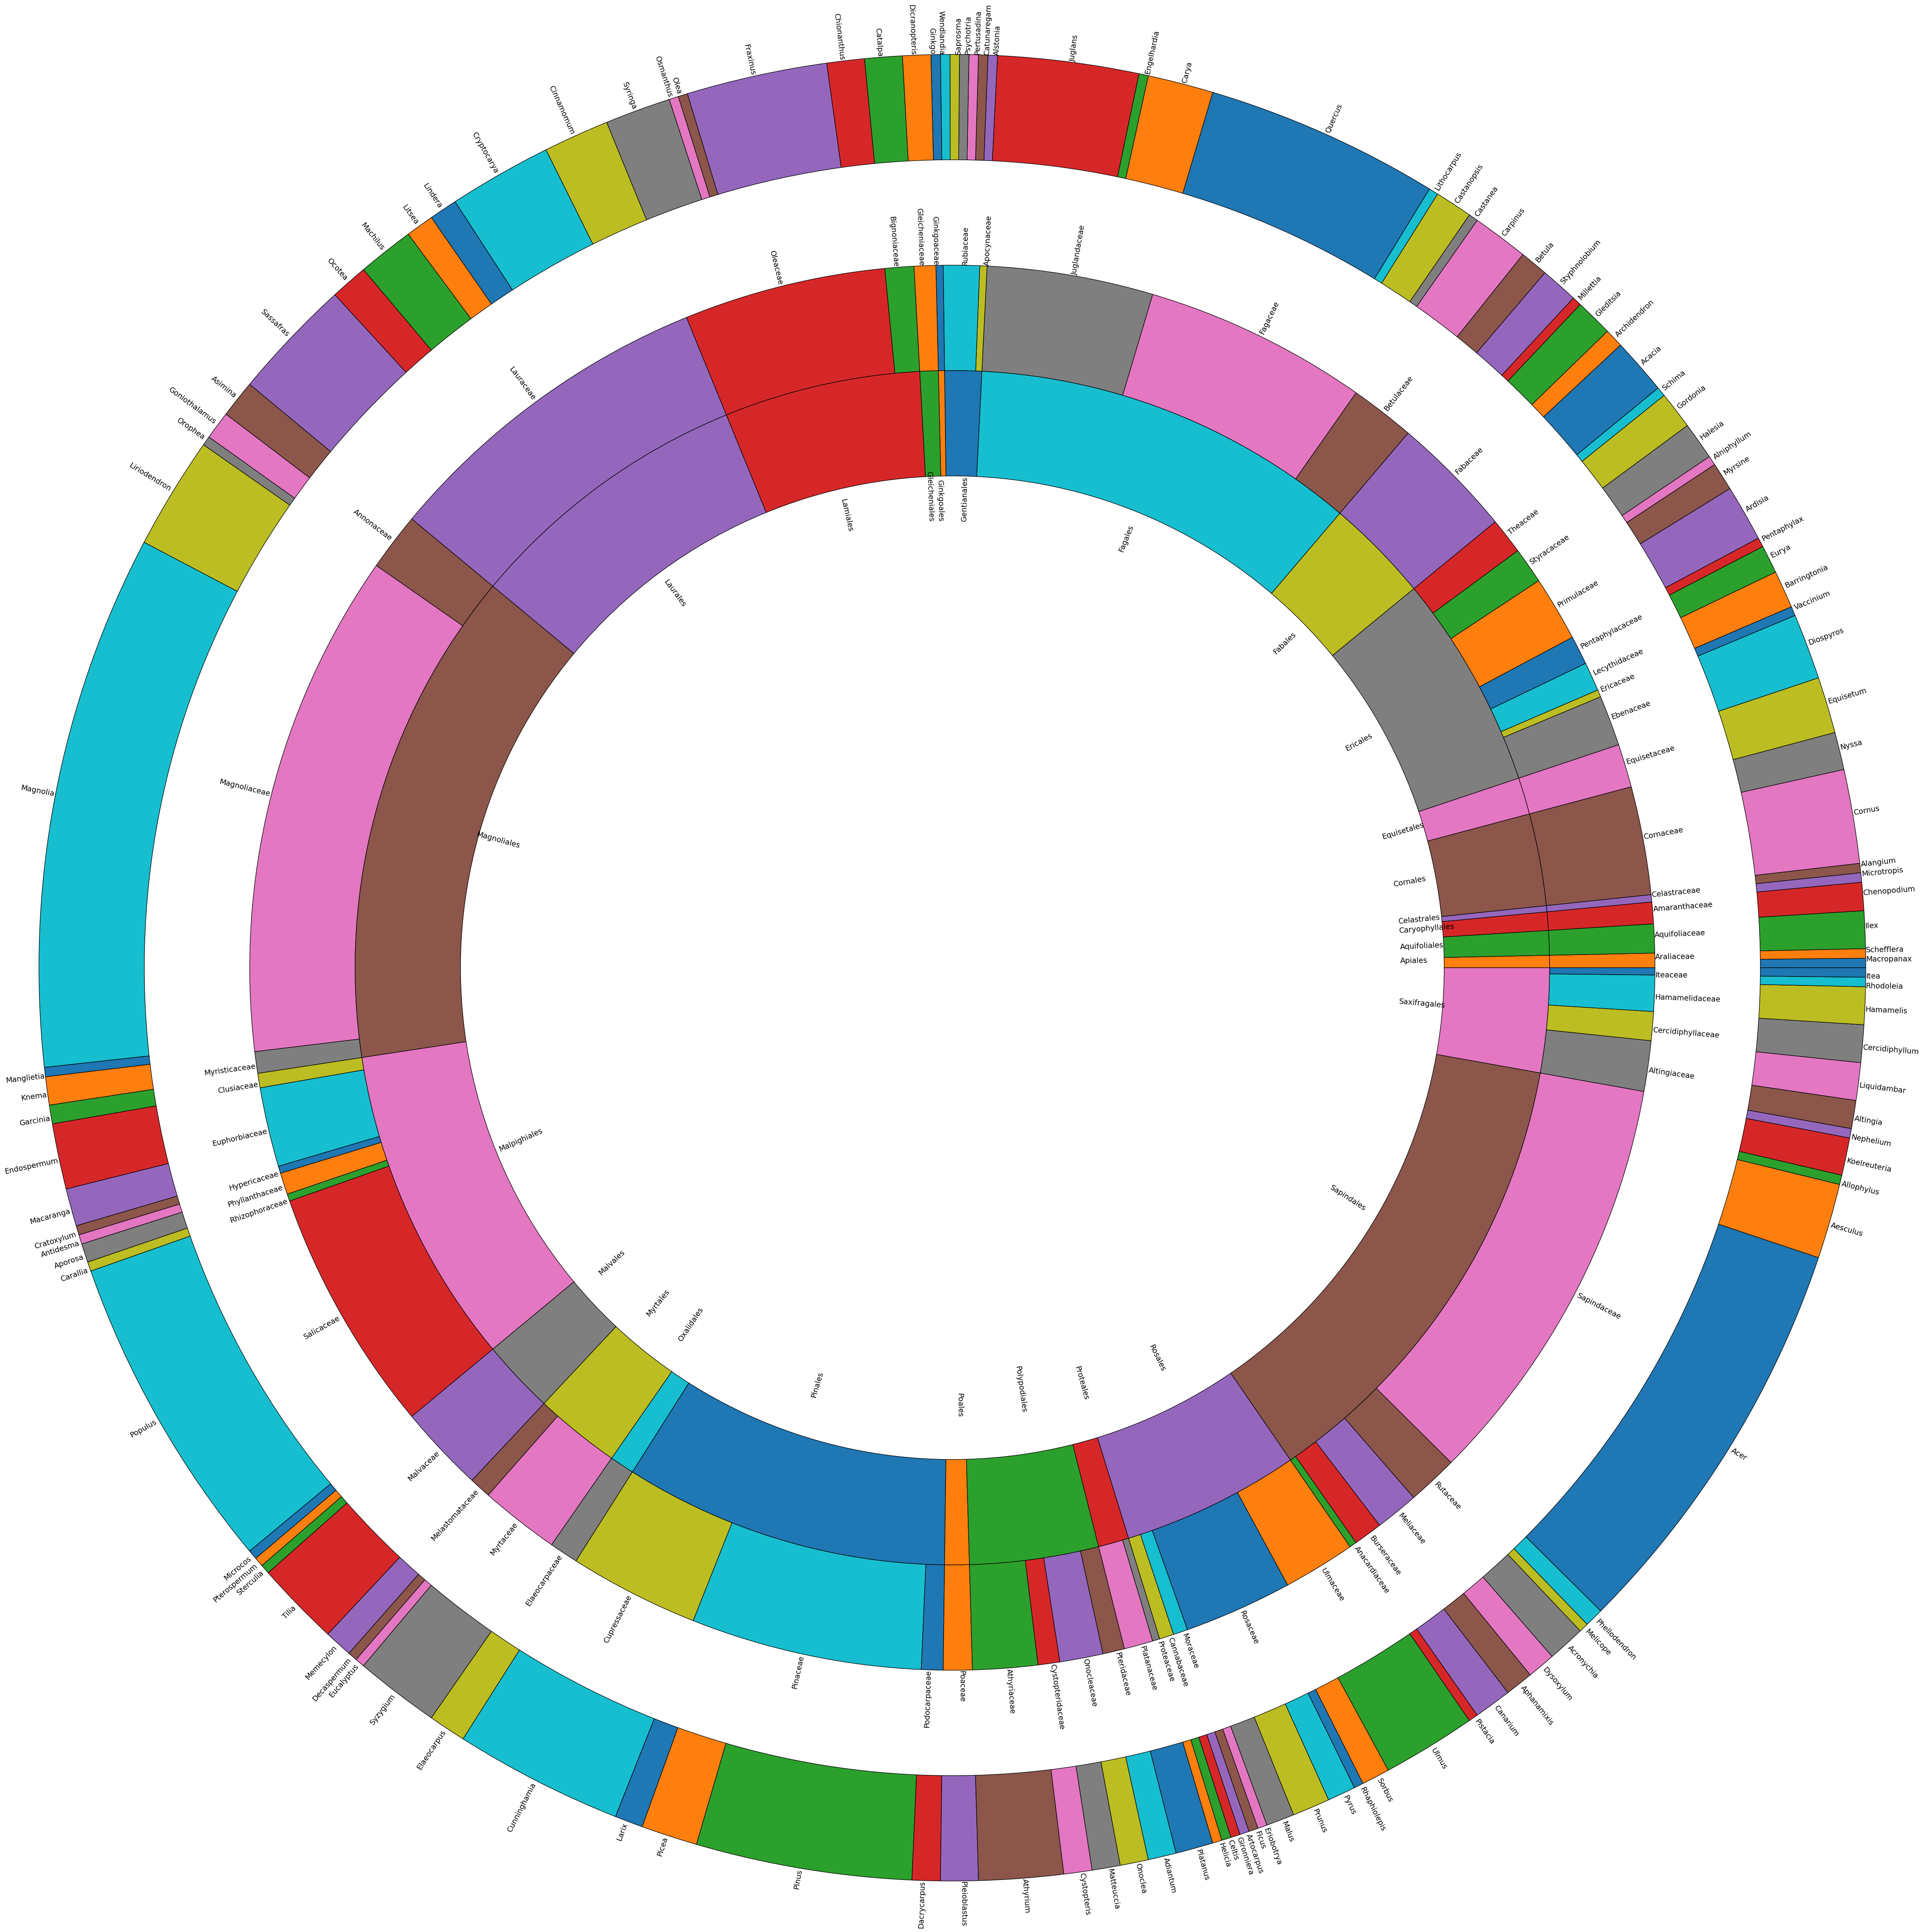

In [33]:
fig, axes = plt.subplots()
fig.set_size_inches(50, 50)
plt.rcParams["font.size"] = 14

RADIUS = 1.00
WIDTH = 0.15
WEDGEPROPERTIES = {
    "width": WIDTH,
    "edgecolor": "black"
}

taxonomically_sorted_data = data.sort_values(["F01290", "F01289", "F01286"])

# genera
axes.pie(x=taxonomically_sorted_data.F01286.value_counts(sort=False).values,
         labels=taxonomically_sorted_data.F01286.value_counts(sort=False).index, # autopct='%1.2f%%', pctdistance=0.5,
         labeldistance=1.0, radius=RADIUS+2*WIDTH, wedgeprops=WEDGEPROPERTIES, rotatelabels=True,
         startangle=0
        )

# family
axes.pie(x=taxonomically_sorted_data.F01289.value_counts(sort=False).values,
         labels=taxonomically_sorted_data.F01289.value_counts(sort=False).index, # autopct='%1.2f%%', pctdistance=0.5,
         labeldistance=1.0, radius=RADIUS, wedgeprops=WEDGEPROPERTIES, rotatelabels=True,
         startangle=0
        )

# order
axes.pie(x=taxonomically_sorted_data.F01290.value_counts(sort=False).values,
         labels=taxonomically_sorted_data.F01290.value_counts(sort=False).index, # autopct='%1.2f%%', pctdistance=0.5,
         labeldistance=0.75, radius=RADIUS-WIDTH, wedgeprops=WEDGEPROPERTIES, rotatelabels=True,
         startangle=0, textprops={"va":"baseline"}
        )

axes.set_aspect("equal")
plt.tight_layout()
plt.show()
# plt.savefig(fname=r"../plots/fred_taxonomy_distribution_4traits.pdf", format="pdf", dpi=1500, bbox_inches="tight")

In [61]:
data.isna().mean()

F00679    0.000000
F00727    0.000000
F00261    0.000000
F00709    0.000000
F00056    0.408243
F00645    0.454367
F01286    0.000000
F01287    0.000000
F01289    0.000000
F01290    0.000000
dtype: float64

In [96]:
# that's alright, we'll stick to taxonlookup then :)

In [104]:
data.loc[:, ["F01286", "family", "order"]].apply(lambda column: np.unique(column).size)

F01286    235
family     92
order      39
dtype: int64

In [54]:
data.F00056.value_counts(dropna=False)

F00056
1.0    294
3.0    157
2.0    152
Name: count, dtype: int64

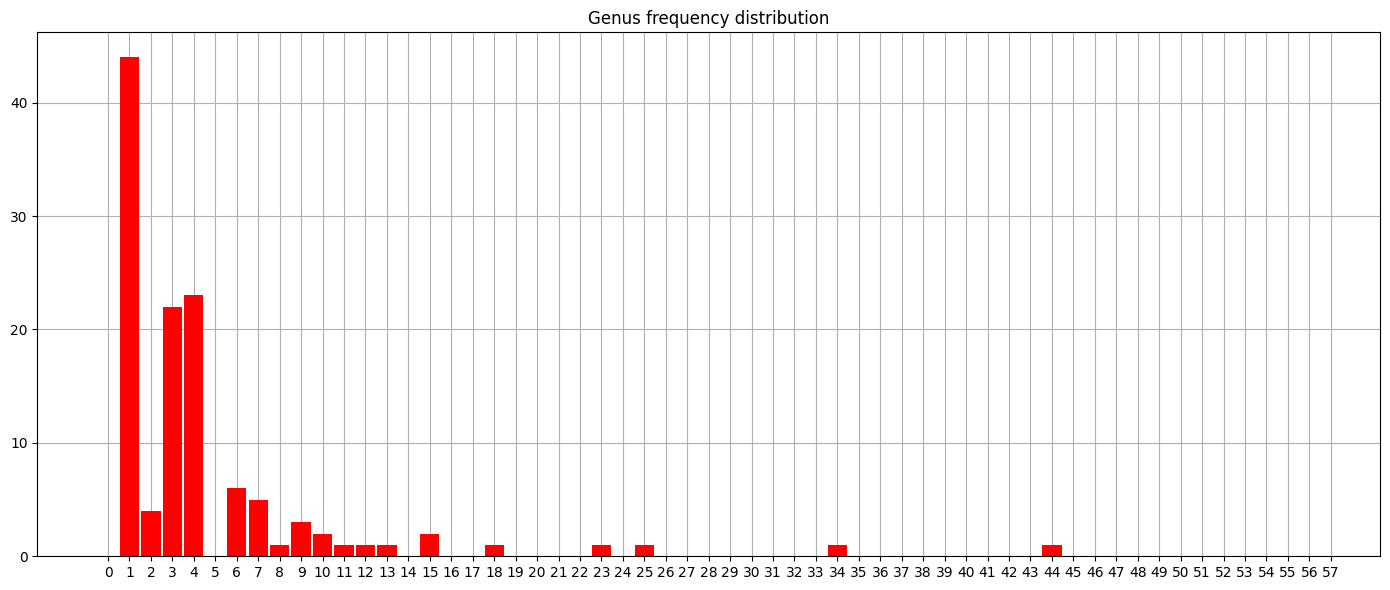

In [55]:
# genus frequency distribution
fig, axes = plt.subplots()
fig.set_size_inches(14, 6)
axes.hist(data.groupby("F01286")["F00679"].count(), bins=np.arange(0-0.5, data.groupby("F01286")["F00679"].count().max()+1-0.5), rwidth=0.9, color="red")
axes.set_xticks(ticks=np.arange(0, data.groupby("F01286")["F00679"].count().max()+1))
axes.set_title("Genus frequency distribution")
axes.set_axisbelow(True)
axes.grid()
plt.tight_layout()
plt.show()

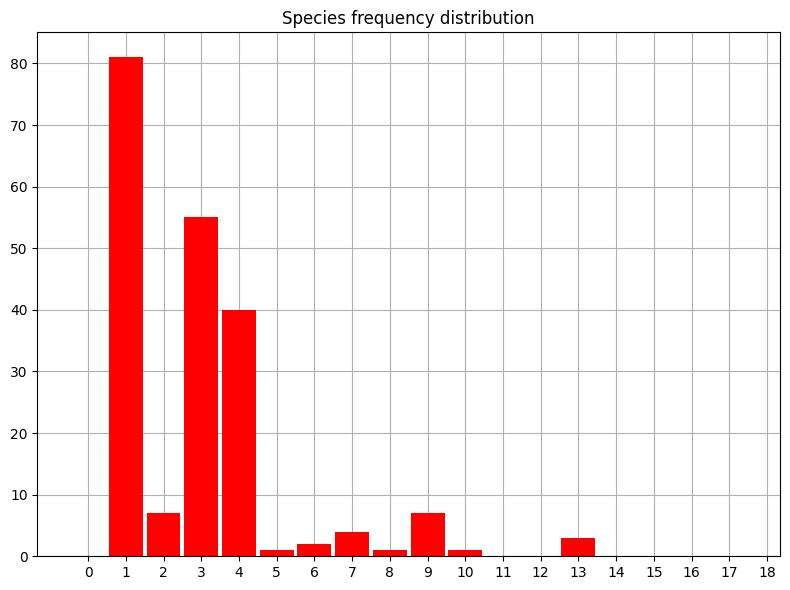

In [56]:
# species frequency distribution

fig, axes = plt.subplots()
fig.set_size_inches(8, 6)
axes.hist(data.groupby(["F01286", "F01287"])["F00679"].count(), bins=np.arange(0-0.5, data.groupby(["F01286", "F01287"])["F00679"].count().max()+1-0.5), rwidth=0.9, color="red")
axes.set_xticks(ticks=np.arange(0, data.groupby(["F01286", "F01287"])["F00679"].count().max()+1))
axes.set_title("Species frequency distribution")
axes.set_axisbelow(True)
axes.grid()
plt.tight_layout()
plt.show()

### ___PCA___
---------------

In [68]:
data.head()

,F00679,F00727,F00261,F00709,F00056,F00645,F01286,F01287,F01289,F01290
0,0.142951,447.167648,18.478265,0.169294,1.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
1,0.249630,166.388374,14.456530,0.160036,2.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
2,0.425085,60.723679,10.760881,0.171351,3.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
3,0.175513,330.424588,22.065220,0.169294,1.0,NaN,Populus,tremula,Salicaceae,Malpighiales
4,0.285828,116.664475,16.304355,0.160041,2.0,NaN,Populus,tremula,Salicaceae,Malpighiales


In [69]:
model = PCA(n_components=2) # we go from 4 traits to 2 PCA axes
projections = model.fit_transform(data.loc[:, CHOSEN_RES_TRAITS])

In [70]:
projections

array([[402.39899468,  -5.66887285],
       [121.59500872,  -4.3192284 ],
       [ 15.87888104,  -5.99269038],
       ...,
       [ -7.72459231,   9.99896645],
       [ 45.3221649 ,   6.58473206],
       [ 27.03060129,  -0.64127104]], shape=(603, 2))

In [84]:
data.F00056.value_counts(dropna=False)

F00056
1.0    294
3.0    157
2.0    152
Name: count, dtype: int64

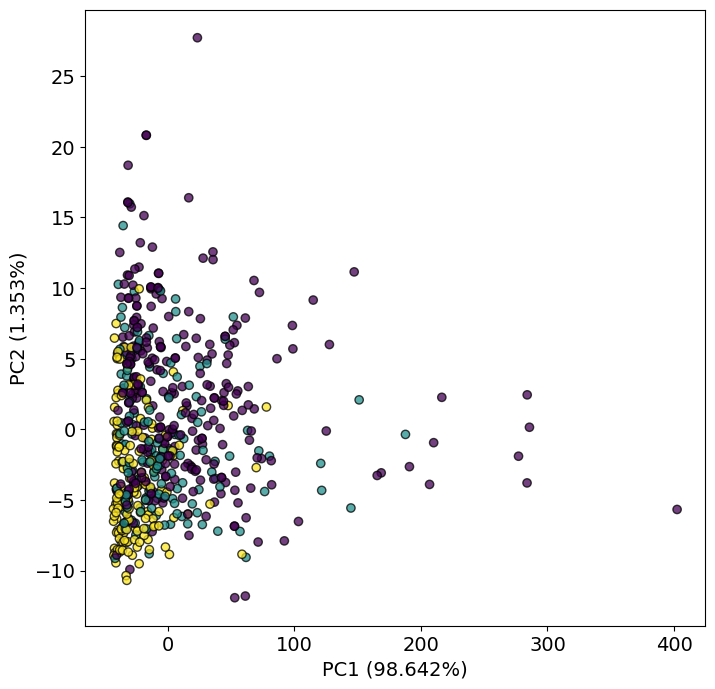

In [72]:
fig, axes = plt.subplots()
fig.set_size_inches(8, 8)
axes.scatter(x=projections[:, 0], y=projections[:, 1], edgecolor="black", c=data.F00056.fillna(value=4), alpha=0.75)
# colour the data points by root order, replace nas with 4
             
axes.set_xlabel(f"PC1 ({model.explained_variance_ratio_[0]*100:.3f}%)")
axes.set_ylabel(f"PC2 ({model.explained_variance_ratio_[1]*100:.3f}%)")
plt.show()

In [73]:
# PCA loadings, coordination of the features
model.components_.T

array([[-2.81914088e-03,  3.09104042e-03],
       [ 9.99812934e-01, -1.91252249e-02],
       [ 1.91307063e-02,  9.99755259e-01],
       [-4.06038888e-04, -1.06814251e-02]])

In [74]:
# proportions of the variance explained by the 2 axes
model.explained_variance_

array([2450.80362   ,   33.61302414])

In [75]:
model.explained_variance_ratio_

array([0.98642302, 0.01352889])

In [76]:
model.explained_variance_ / model.explained_variance_.sum() # pfff

array([0.98647046, 0.01352954])

In [77]:
CHOSEN_RES_TRAITS, model.mean_

(['F00679', 'F00727', 'F00261', 'F00709'],
 array([ 0.44442477, 44.73307527, 16.45082039,  0.33428621]))

In [78]:
# maximum absolute values of points on each axes
np.abs(projections).max(axis=0)

array([402.39899468,  27.72236154])

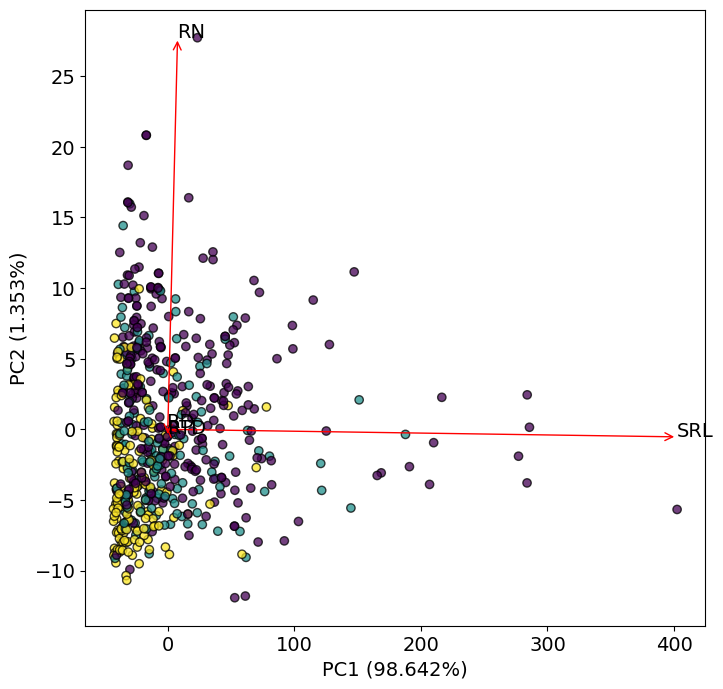

In [79]:
# WITHOUT SCALING

fig, axes = plt.subplots()
fig.set_size_inches(8, 8)
axes.scatter(x=projections[:, 0], y=projections[:, 1], edgecolor="black", c=data.F00056.fillna(value=4), alpha=0.75)
for (label, (dx, dy)) in zip(CHOSEN_RES_TRAITS_NAMES, np.abs(projections).max(axis=0) * model.components_.T):
    axes.annotate(text='', xytext=(0, 0), xy=(dx, dy), arrowprops={"arrowstyle": "->", "color": "red"})
    axes.text(x=dx, y=dy, s=label)
axes.set_xlabel(f"PC1 ({model.explained_variance_ratio_[0]*100:.3f}%)")
axes.set_ylabel(f"PC2 ({model.explained_variance_ratio_[1]*100:.3f}%)")
plt.show()

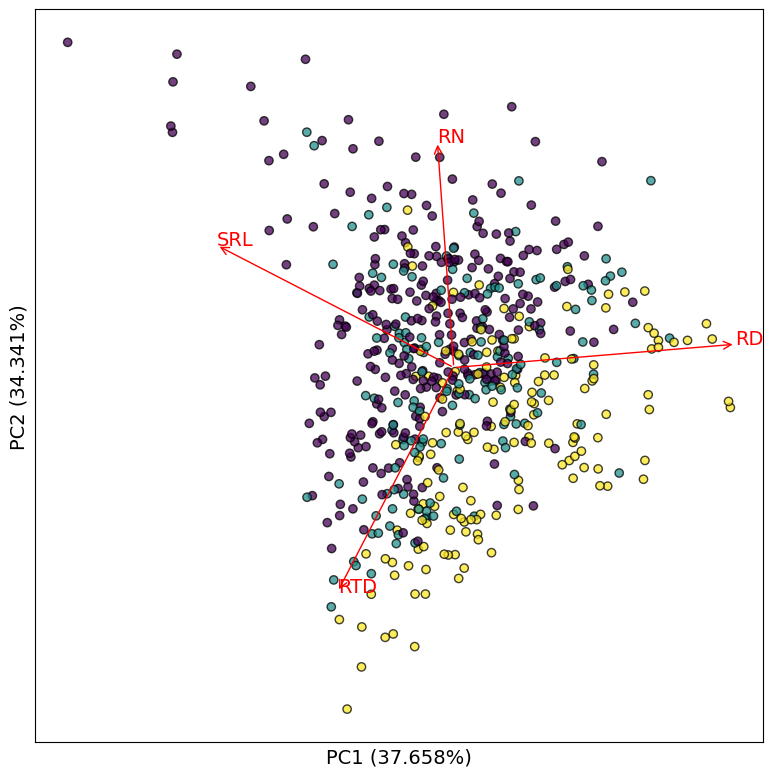

In [80]:
# WITH SCALING

scaled_data = StandardScaler().fit_transform(data.loc[:, CHOSEN_RES_TRAITS])
model = PCA(n_components=2).fit(scaled_data)
projections = model.transform(scaled_data)

fig, axes = plt.subplots()
fig.set_size_inches(8, 8)
axes.scatter(x=projections[:, 0], y=projections[:, 1], edgecolor="black", c=data.F00056.fillna(value=4), alpha=0.75)
for (label, (dx, dy)) in zip(CHOSEN_RES_TRAITS_NAMES, np.abs(projections).max(axis=0) * model.components_.T):
    axes.annotate(text='', xytext=(0, 0), xy=(dx, dy), arrowprops={"arrowstyle": "->", "color": "red"})
    axes.text(x=dx, y=dy, s=label, fontdict={"color": "red"})
axes.set_xlabel(f"PC1 ({model.explained_variance_ratio_[0]*100:.3f}%)")
axes.set_ylabel(f"PC2 ({model.explained_variance_ratio_[1]*100:.3f}%)")
axes.set_xticks([])
axes.set_yticks([])
plt.tight_layout()
plt.show()
# plt.savefig(fname=r"../plots/fred_4traits_pca.jpeg", format="jpeg", dpi=1000)

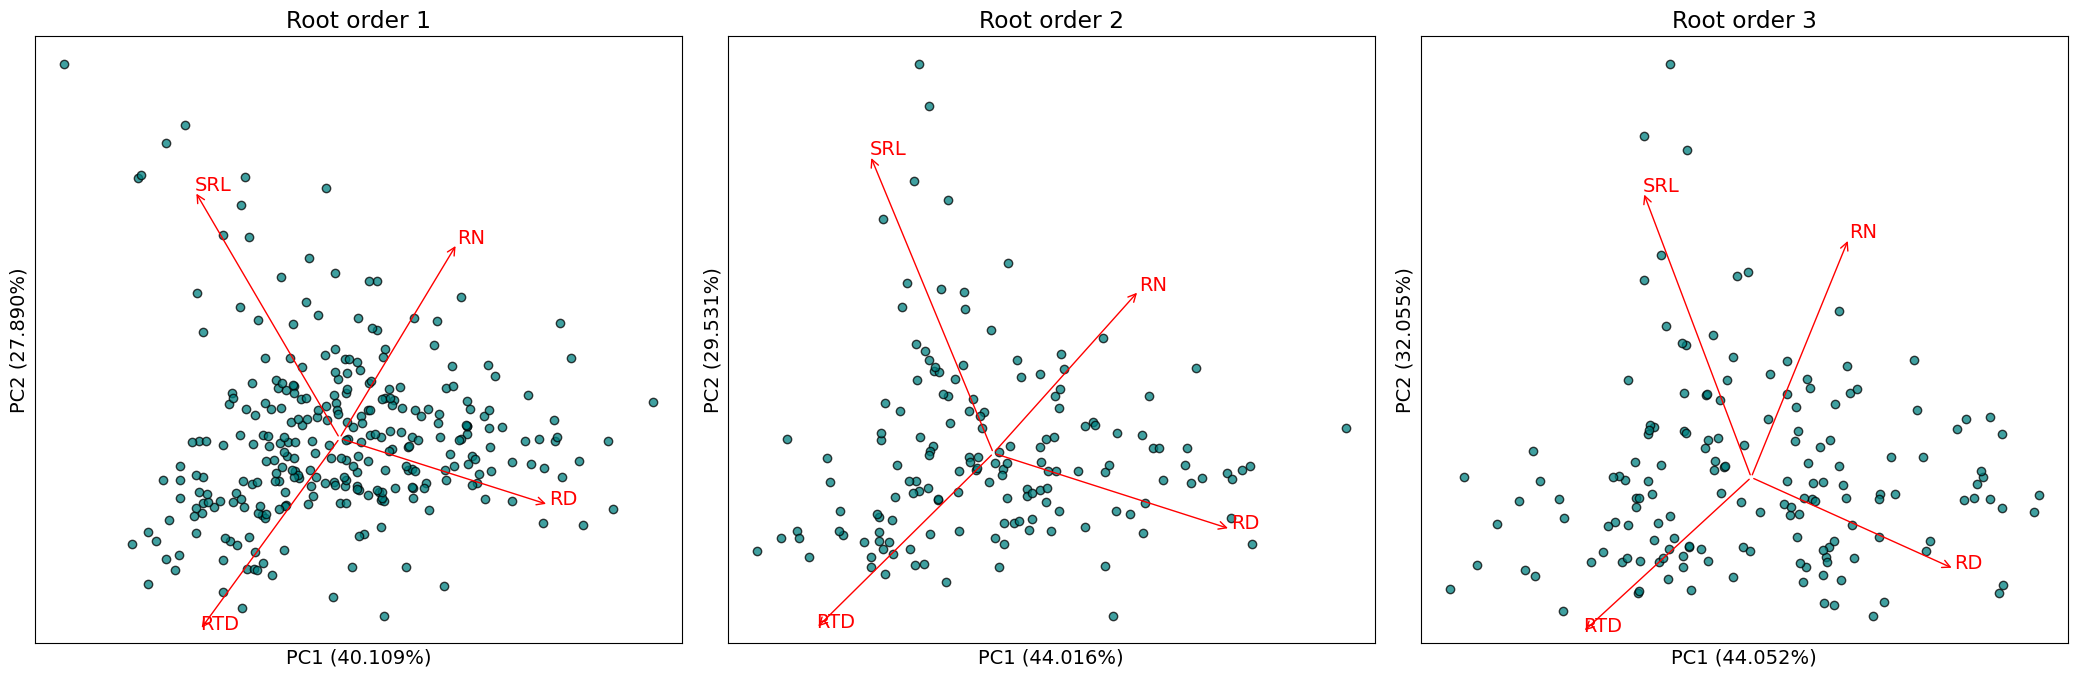

In [34]:
loadings = dict()

fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(21, 7)

for (axis, (order, df)) in zip(axes.flatten(), data.groupby("F00056", dropna=False)):
    scaled_data = StandardScaler().fit_transform(df.loc[:, CHOSEN_RES_TRAITS])
    model = PCA(n_components=2).fit(scaled_data)
    projections = model.transform(scaled_data)
    loadings[order] = model.components_.T * np.sqrt(model.explained_variance_)
    
    axis.scatter(x=projections[:, 0], y=projections[:, 1], edgecolor="black", alpha=0.75, color="teal")
    axis.set_xlabel(f"PC1 ({model.explained_variance_ratio_[0]*100:.3f}%)")
    axis.set_ylabel(f"PC2 ({model.explained_variance_ratio_[1]*100:.3f}%)")
    axis.set_xticks([])
    axis.set_yticks([])
    try:
        axis.set_title(f"Root order {int(order)}")
    except ValueError:
        axis.set_title("Root order unknown")
    
    for (label, (dx, dy)) in zip(CHOSEN_RES_TRAITS_NAMES, np.abs(projections).max(axis=0) * model.components_.T):
        axis.annotate(text='', xytext=(0, 0), xy=(dx, dy), arrowprops={"arrowstyle": "->", "color": "red"})
        axis.text(x=dx, y=dy, s=label, fontdict={"color": "red"})
        

plt.tight_layout()
plt.show()
# plt.savefig(fname=r"../plots/pca_order_grouped.jpeg", format="jpeg", dpi=1000)

### ___Iris___
-------------------

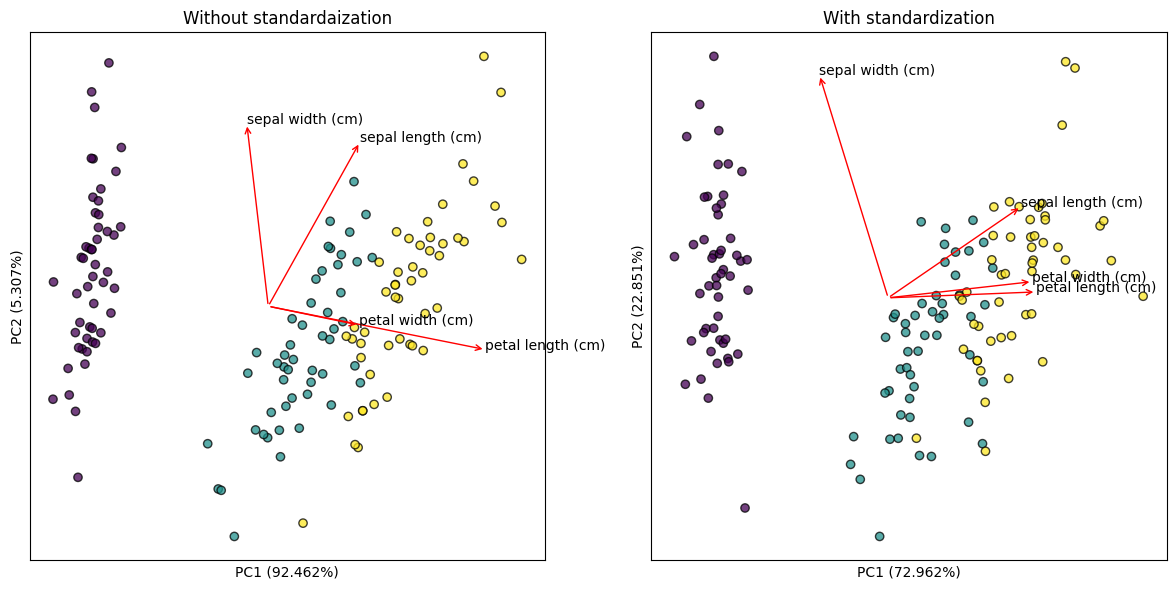

In [47]:
iris = datasets.load_iris()
iris_data_scaled = StandardScaler().fit_transform(iris.get("data"))
iris_model = PCA(n_components=2).fit(iris.get("data"))
iris_model_scaled = PCA(n_components=2).fit(iris_data_scaled)

comps = iris_model.transform(iris.get("data"))
scaled_comps = iris_model_scaled.transform(iris_data_scaled)

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12, 6)
plt.rcParams["font.size"] = 10

for (ax, proj, model, title) in zip(axes, (comps, scaled_comps), (iris_model, iris_model_scaled), ("Without standardaization", "With standardization")):
    ax.scatter(x=proj[:, 0], y=proj[:, 1], edgecolor="black", c=iris.get("target"), alpha=0.75)
    for (label, (dx, dy)) in zip(iris.get("feature_names"), np.abs(proj).max(axis=0) * model.components_.T):
        ax.annotate(text='', xytext=(0, 0), xy=(dx, dy), arrowprops={"arrowstyle": "->", "color": "red"})
        ax.text(x=dx, y=dy, s=label)
    ax.set_xlabel(f"PC1 ({model.explained_variance_ratio_[0]*100:.3f}%)")
    ax.set_ylabel(f"PC2 ({model.explained_variance_ratio_[1]*100:.3f}%)")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [53]:
loadings

{1.0: array([[ 0.84766266, -0.18777859],
        [-0.58657196,  0.69834381],
        [ 0.47599497,  0.55023035],
        [-0.56626068, -0.54196755]]),
 2.0: array([[ 0.8968053 , -0.21269235],
        [-0.46574664,  0.83402129],
        [ 0.5499396 ,  0.45534071],
        [-0.6698522 , -0.49081924]]),
 3.0: array([[ 0.89725778, -0.25142611],
        [-0.47743478,  0.78423307],
        [ 0.43150184,  0.65672538],
        [-0.74443361, -0.42533809]]),
 nan: array([[-0.05860482,  0.96958441],
        [-0.81936076, -0.46231022],
        [-0.81103872,  0.28604859],
        [ 0.84110998, -0.10697775]])}

In [67]:
# multiindex
idx = pd.MultiIndex.from_tuples([(order, name) for order in loadings.keys() for name in CHOSEN_RES_TRAITS_NAMES])

In [70]:
loadings

{1.0: array([[ 0.84766266, -0.18777859],
        [-0.58657196,  0.69834381],
        [ 0.47599497,  0.55023035],
        [-0.56626068, -0.54196755]]),
 2.0: array([[ 0.8968053 , -0.21269235],
        [-0.46574664,  0.83402129],
        [ 0.5499396 ,  0.45534071],
        [-0.6698522 , -0.49081924]]),
 3.0: array([[ 0.89725778, -0.25142611],
        [-0.47743478,  0.78423307],
        [ 0.43150184,  0.65672538],
        [-0.74443361, -0.42533809]]),
 nan: array([[-0.05860482,  0.96958441],
        [-0.81936076, -0.46231022],
        [-0.81103872,  0.28604859],
        [ 0.84110998, -0.10697775]])}

In [49]:
# https://www.jcchouinard.com/pca-loadings/
# loadings_df = pd.DataFrame(data=np.array([(a, b) for _ in loadings.values() for (a, b) in _]), index=idx, columns=("PC1", "PC2"))
# loadings_df.to_csv(path_or_buf="../data/fred_pca.csv", na_rep="NA", float_format="%.4f")

In [50]:
# double check the PCA results with R
# data.rename(mapper={o: n for o, n in zip(CHOSEN_RES_TRAITS, CHOSEN_RES_TRAITS_NAMES)}, axis=1).to_csv(r"../data/fred_subset.csv", float_format="%.6f", na_rep="NA")